# **1. 모델 설계**

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


데이터 다운: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [2]:
import os

root_path = '/Users/qraft_dongryeol/Desktop/personal/auto/24-2_DS_assignment/Week_03/cityscapes_data'

data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


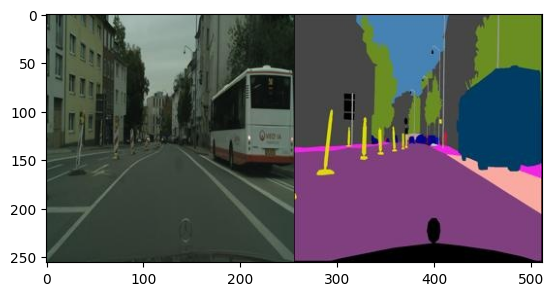

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [4]:
import numpy as np
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [5]:
from sklearn.cluster import KMeans
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/Users/qraft_dongryeol/.pyenv/versions/3.9.13/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


KMeans(n_clusters=10)

In [6]:
def split_image(image) :
   image = np.array(image)
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

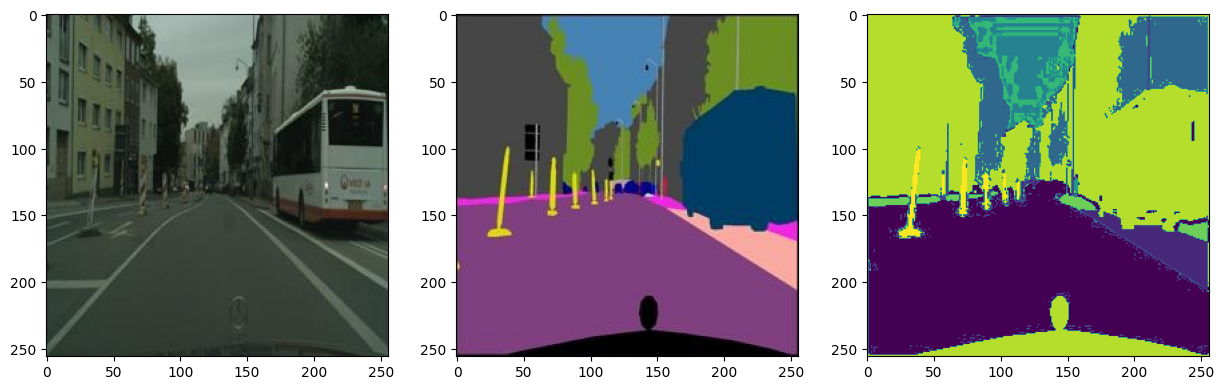

In [7]:
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model, fraction=0.01):
      self.image_dir = image_dir
      self.image_fns = os.listdir(image_dir)
      self.label_model = label_model
      
      # 전체 데이터셋의 일부만 사용하도록 조정
      self.image_fns = self.image_fns[:int(len(self.image_fns) * fraction)]

  def __len__(self) :
    return len(self.image_fns)

  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label

  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
                        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

297
torch.Size([3, 256, 256])
torch.Size([256, 256])


In [23]:
dataset.__dict__

{'image_dir': '/Users/qraft_dongryeol/Desktop/personal/auto/24-2_DS_assignment/Week_03/cityscapes_data/train',
 'image_fns': ['63.jpg',
  '823.jpg',
  '2666.jpg',
  '2100.jpg',
  '1409.jpg',
  '189.jpg',
  '2114.jpg',
  '2672.jpg',
  '77.jpg',
  '837.jpg',
  '2882.jpg',
  '1353.jpg',
  '1435.jpg',
  '2128.jpg',
  '1421.jpg',
  '1347.jpg',
  '2896.jpg',
  '638.jpg',
  '2869.jpg',
  '1390.jpg',
  '604.jpg',
  '2699.jpg',
  '2841.jpg',
  '162.jpg',
  '176.jpg',
  '2855.jpg',
  '88.jpg',
  '610.jpg',
  '1384.jpg',
  '2302.jpg',
  '2464.jpg',
  '1179.jpg',
  '2470.jpg',
  '2316.jpg',
  '1637.jpg',
  '1151.jpg',
  '2458.jpg',
  '1145.jpg',
  '1623.jpg',
  '1810.jpg',
  '1804.jpg',
  '348.jpg',
  '360.jpg',
  '406.jpg',
  '1192.jpg',
  '1186.jpg',
  '412.jpg',
  '1838.jpg',
  '374.jpg',
  '2276.jpg',
  '2510.jpg',
  '1019.jpg',
  '599.jpg',
  '2504.jpg',
  '2262.jpg',
  '1743.jpg',
  '1025.jpg',
  '2538.jpg',
  '1031.jpg',
  '1757.jpg',
  '228.jpg',
  '1964.jpg',
  '1970.jpg',
  '214.jpg',
  

In [24]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        def set_block(in_channels, out_channels, stride=1, padding=1, kernel_size=3):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
            return block
        
        # Encoder blocks
        self.e1_1 = set_block(3, 64)
        self.e1_2 = set_block(64, 64)
        self.em_1 = nn.MaxPool2d(2, 2)

        self.e2_1 = set_block(64, 128)
        self.e2_2 = set_block(128, 128)
        self.em_2 = nn.MaxPool2d(2, 2)

        self.e3_1 = set_block(128, 256)
        self.e3_2 = set_block(256, 256)
        self.em_3 = nn.MaxPool2d(2, 2)

        self.e4_1 = set_block(256, 512)
        self.e4_2 = set_block(512, 512)
        self.em_4 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.n_1 = set_block(512, 1024)
        self.n_2 = set_block(1024, 1024)

        # Decoder blocks
        self.dm_4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.d4_2 = set_block(1024, 512)
        self.d4_1 = set_block(512, 512)

        self.dm_3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.d3_2 = set_block(512, 256)
        self.d3_1 = set_block(256, 256)

        self.dm_2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.d2_2 = set_block(256, 128)
        self.d2_1 = set_block(128, 128)

        self.dm_1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.d1_2 = set_block(128, 64)
        self.d1_1 = set_block(64, 64)

        # Final output layer
        self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.e1_1(x)
        e1 = self.e1_2(e1)
        em1 = self.em_1(e1)
        e2 = self.e2_1(em1)
        e2 = self.e2_2(e2)
        em2 = self.em_2(e2)
        e3 = self.e3_1(em2)
        e3 = self.e3_2(e3)
        em3 = self.em_3(e3)
        e4 = self.e4_1(em3)
        e4 = self.e4_2(e4)
        em4 = self.em_4(e4)
        n1 = self.n_1(em4)
        n2 = self.n_2(n1)

        # Decoder
        dm4 = self.dm_4(n2)
        d4 = self.d4_2(torch.cat([dm4, e4], dim=1))
        d4 = self.d4_1(d4)
        dm3 = self.dm_3(d4)
        d3 = self.d3_2(torch.cat([dm3, e3], dim=1))
        d3 = self.d3_1(d3)
        dm2 = self.dm_2(d3)
        d2 = self.d2_2(torch.cat([dm2, e2], dim=1))
        d2 = self.d2_1(d2)
        dm1 = self.dm_1(d2)
        d1 = self.d1_2(torch.cat([dm1, e1], dim=1))
        d1 = self.d1_1(d1)

        # Output
        output = self.fc(d1)

        return output


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = UNet(num_classes=num_classes)
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

297 75
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [26]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# **2. 모델 학습**

In [28]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 하이퍼파라미터 자율설정

batch_size = 4

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in (range(epochs)):
    print(f"Epoch {epoch+1}/{epochs} 시작")
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        print("Batch 시작")
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    print(f"Epoch {epoch+1} Loss: {epoch_loss / len(data_loader)}")
    epoch_losses.append(epoch_loss / len(data_loader))



Epoch 1/10 시작


  0%|          | 0/75 [00:00<?, ?it/s]

Batch 시작


  1%|▏         | 1/75 [00:05<06:12,  5.04s/it]

Batch 시작


  3%|▎         | 2/75 [00:13<08:17,  6.82s/it]

Batch 시작


  4%|▍         | 3/75 [00:20<08:15,  6.89s/it]

Batch 시작


In [ ]:
print(len(epoch_losses))
print(epoch_losses)

10
[0.965046497121934, 0.7826777537583663, 0.7225772756482324, 0.680771268623811, 0.6464523440327055, 0.619710575508815, 0.5938139440471767, 0.5763768379886945, 0.5542146597177752, 0.5294514585246322]


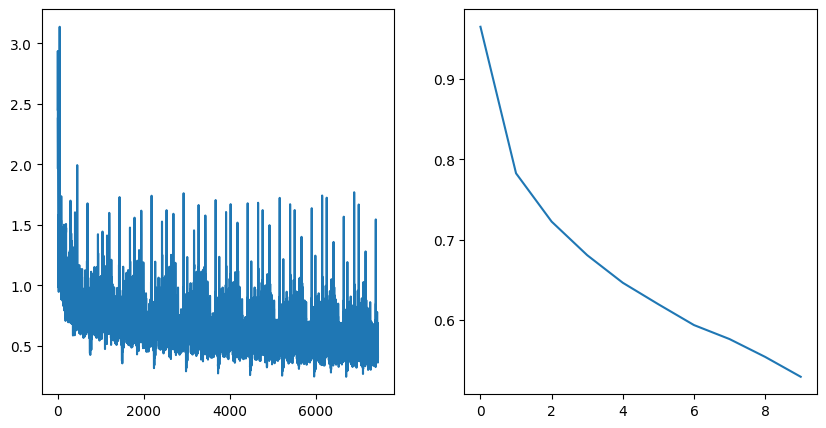

In [ ]:
##TODO
loss plot 그리기

plt.show()

In [ ]:
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

# **3. 모델 평가**

In [ ]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

/tmp/ipykernel_16231/1516665964.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


Exception ignored in: <function tqdm.__del__ at 0x7f14c8653e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f14c8653e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

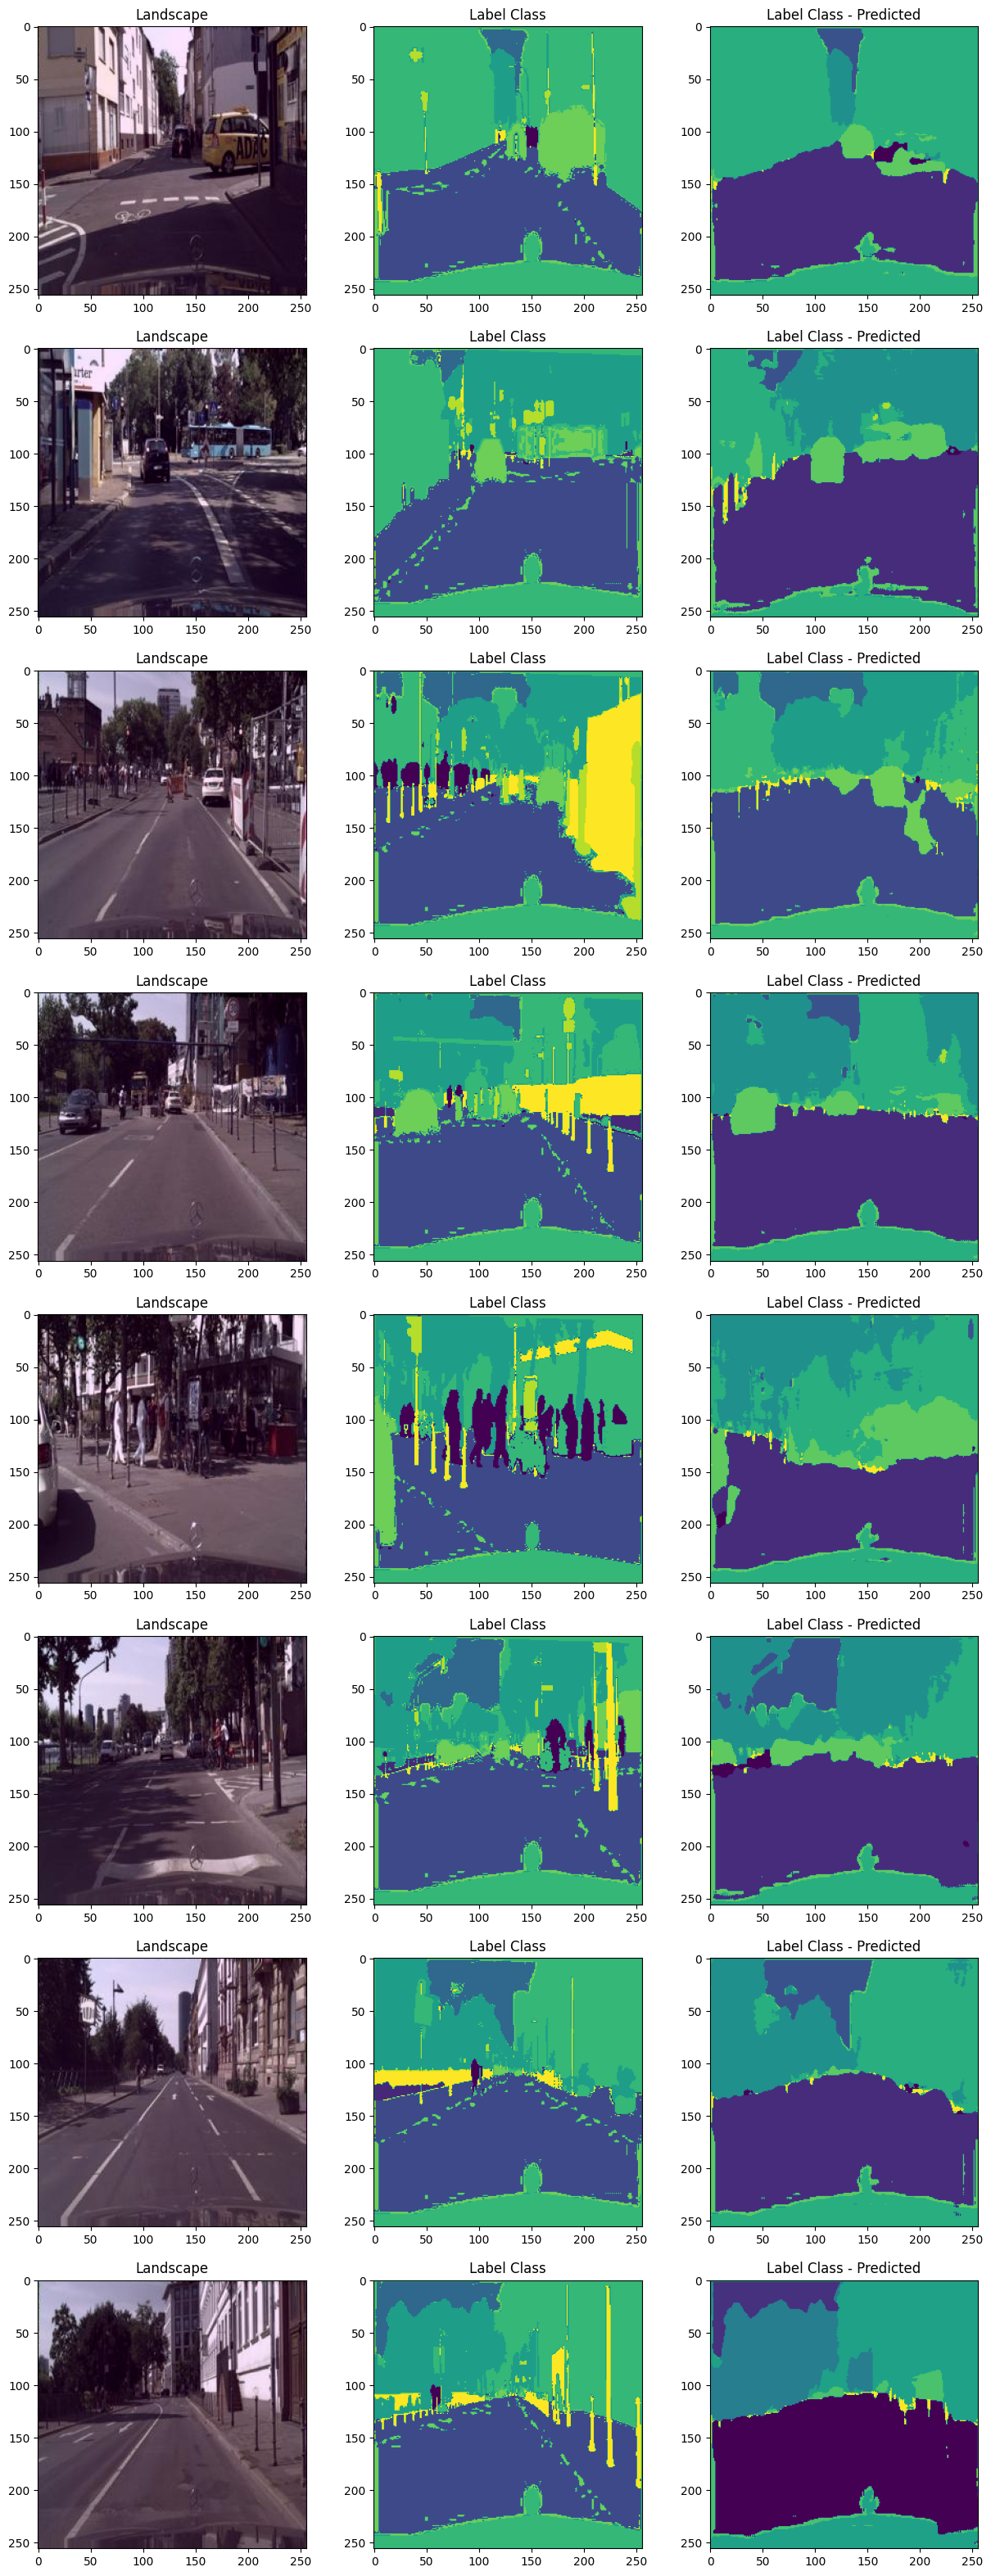

In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

# **4. IoU Score**

In [ ]:
##TODO

IoU score 계산하기 에이 이건 쉽다

0.9817180091332287
